# 57 LSTM

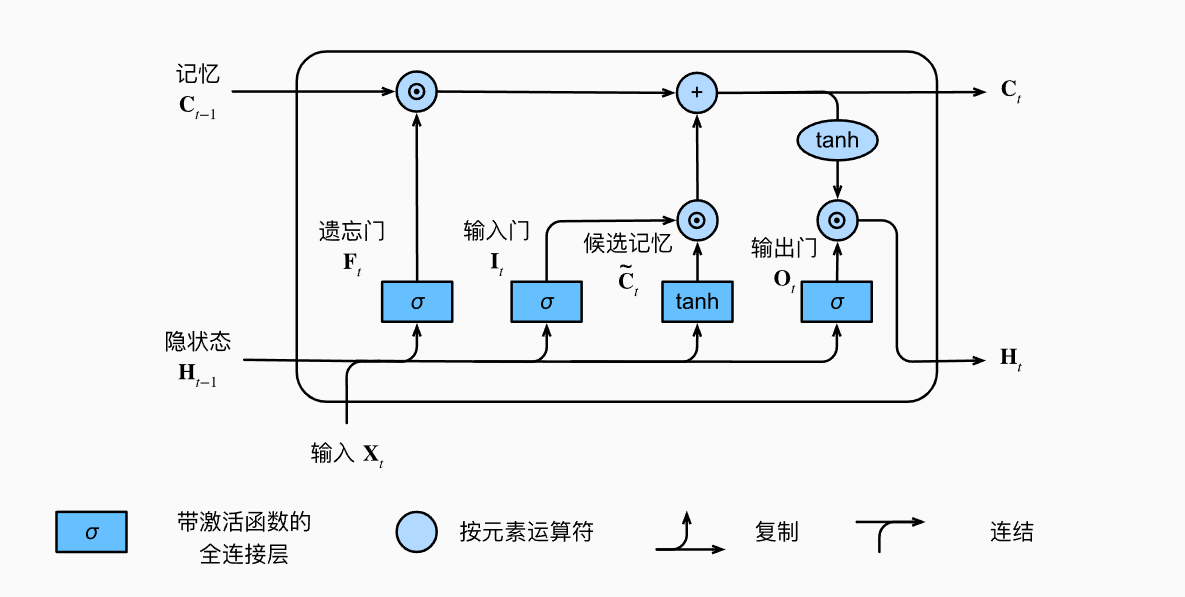

忘记门:将值朝0减少</br>
输入门:决定不是忽略掉输入数据</br>
输出门:决定是不是使用隐状态</br>
预测时，对于每一次输入，权重矩阵不变，改变的有H和C

## 1 从零开始实现
首先加载时光机器数据集

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

### 1.1 初始化模型参数
接下来，我们需要定义和初始化模型参数。如前所述，超参数num_hiddens定义隐藏单元的数量。我们按照标准差0.01的高斯分布初始化权重，并将偏置项设为0。


In [2]:
def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xi, W_hi, b_i = three()  # 输入门参数
    W_xf, W_hf, b_f = three()  # 遗忘门参数
    W_xo, W_ho, b_o = three()  # 输出门参数
    W_xc, W_hc, b_c = three()  # 候选记忆元参数
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc,
              b_c, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

### 1.2 定义模型
在初始化函数中，长短期记忆网络的隐状态需要返回一个额外的记忆元，单元的值为0，形状为（批量大小，隐藏单元数）。因此，我们得到以下的状态初始化。

In [3]:
def init_lstm_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),
            torch.zeros((batch_size, num_hiddens), device=device))

实际模型的定义与我们前面讨论的一样：提供三个门和一个额外的记忆元。 请注意，只有隐状态才会传递到输出层，而记忆元Ct不直接参与输出计算。

In [4]:
def lstm(inputs, state, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
     W_hq, b_q] = params
    (H, C) = state
    outputs = []
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        Y = (H @ W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, C)

### 1.3 训练和预测
通过RNNModelScratch类来训练一个长短期记忆网络

perplexity 1.1, 30263.6 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


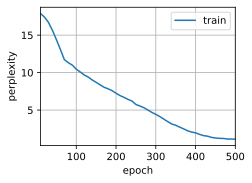

In [5]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params,
                            init_lstm_state, lstm)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## 2 简洁实现

perplexity 1.0, 342998.4 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


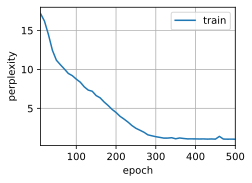

In [6]:
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

长短期记忆网络有三种类型的门：输入门、遗忘门和输出门。
</br>
长短期记忆网络的隐藏层输出包括“隐状态”和“记忆元”。只有隐状态会传递到输出层，而记忆元完全属于内部信息。
</br>
长短期记忆网络可以缓解梯度消失和梯度爆炸。